In [1]:
%%file Barrier_Scenario.m
% European Barrier Option Price Scenario Analysis

function price = Barrier_Scenario(C_P, S, X, r, T, vol, type, H, q, S_ch, vol_ch)
    %S_ch : 주가 변화율 시나리오
    S = S * (1+S_ch);
    
    %vol_ch : 변동성 변동 시나리오
    vol   = vol + vol_ch;
    price = zeros(length(S), length(vol));
    for i=1:length(S)
        for j=1:length(vol)
            price(i, j) = BS_Barrier(C_P, S(i), X, r, T, vol(j), type, H, q);
        end
    end
    
    %Mesh Graph
    [S_ch, vol_ch] = meshgrid(S_ch, vol_ch);
    mesh(S_ch, vol_ch, price')
    xlabel('주가변화율(%)')
    ylabel('변동성변동(%)')
    zlabel('Option Price')
    title('주가와 변동성 변동에 따른 옵션가격 변동')

Created file '/Users/changsoo/Desktop/논문/Matlab/Barrier_Scenario.m'.



ans =

  1 ~ 7번 열

    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000    0.0000    0.0000    0.0001    0.0003
    0.0000    0.0000    0.0000    0.0000    0.0001    0.0007    0.0026
    0.0000    0.0000    0.0000    0.0003    0.0017    0.0059    0.0155
    0.0000    0.0001    0.0007    0.0039    0.0132    0.0331    0.0667
    0.0001    0.0016    0.0088    0.0290    0.0688    0.1317    0.2158
    0.0037    0.0207    0.0642    0.1429    0.2570    0.3983    0.5525
    0.0523    0.1480    0.3007    0.5008    0.7278    0.9554    1.1599
    0.3651    0.6518    0.9840    1.3247    1.6340    1.8811    2.0520
    1.4660    1.9527    2.4033    2.7648    3.0041    3.1175    3.1222
    3.8591    4.3058    4.5987    4.6998    4.6273    4.4261    4.1443
    7.4172    7.3910    7.1111    6.6373    6.0566    5.4407    4.8374
   11.1311   10.1573    9.0096    7.8493    6.7674    5.8032    4.9665
   13.1838   11.1480    9.2980    7.7131    6.3935    5.3

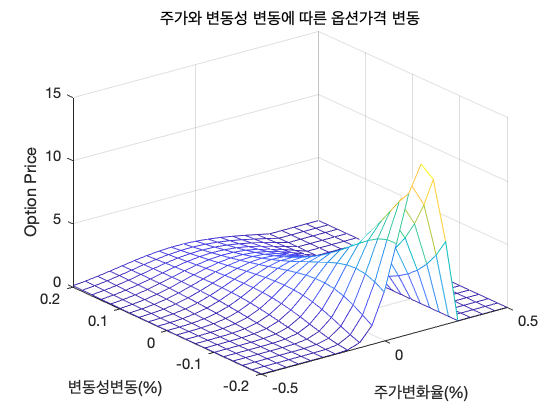

In [2]:
Barrier_Scenario('C', 100, 100, 0.05, 0.5, 0.3, 'uo', 130, 0.01, [-0.5:0.05:0.5], [-0.2:0.02:0.2])

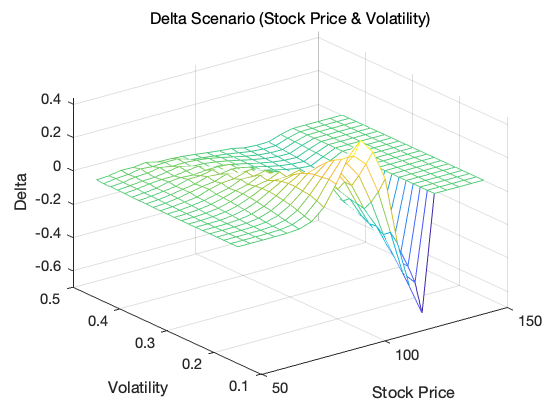

In [3]:
%European Barrier Option Delta Scenario Analysis

Style = 'EU'; C_P = 'C'; Greeks = 'delta';
S=100; X=100; r=0.05; T=0.5; vol=0.3;
KO = 'U'; barrier = 130; q=0.01; N=100;

%S & Volatility Scenario Set
S_Chg = S   * (1+[-0.5:0.05:0.5]);
V_Chg = vol * (1+[-0.5:0.05:0.5]);
D_Chg = zeros(length(S_Chg), length(V_Chg));

%S & Volatility Scenario Set에 따른 Delta
for i=1:length(S_Chg)
    for j=1:length(V_Chg)
        if S_Chg(i) >= barrier
            D_Chg(i, j) =0;
        else
            D_Chg(i, j) = Trinomial_KnockOut_Greeks(Style, C_P, Greeks, S_Chg(i), X, r, T, V_Chg(j), KO, barrier, q, N);
        end
    end
end

%Mesh Graph
[S_Chg V_Chg] = meshgrid(S_Chg, V_Chg);
mesh(S_Chg, V_Chg, D_Chg')
title('Delta Scenario (Stock Price & Volatility)')
xlabel('Stock Price')
ylabel('Volatility')
zlabel('Delta')

### 다이아몬드펀드 TRS거래 상품분해

상품종류 | 채권 | 엔화 put option | 바트화 put option
------ | ----| -------------- | ---------------
명목금액 | 159만달러(=5300만 * 0.3) | 5,300만달러 | 5,300만달러
수량 | | 122 | 129.42(=5*25.884) 
행사가격 | | 0.0082(=1/122) | 0.0464(=6/(5*25.884)) 
현재가격 / / 0.0082(=1/122, ATM) / 0.0386(=1/25.884, ITM) 
손익구조 / 달러 금리상승시 손실 / 엔화 평가절하시 이익 / 바트화 평가절하시 손실



In [4]:
%%file GC_TRS.m
%Diamond Fund TRS Closed-Form

function price = GC_TRS(Notional, Y0, B0, Ur, Yr, Br, Y_vol, B_vol, T)

    %Bond Pricing
    Bond = Notional * (-0.03) * exp(-Ur*T);
    
    %Yen Put Pricing
    Yen_Put = Notional * -Y0 * BS_Vanilla('P', 1/Y0, 1/Y0, Ur, T, Y_vol, Yr);
    
    %Baht Put Pricing
    Baht_Put = Notional * 5 * B0 * BS_Vanilla('P', 1/B0, 6/(5*B0), Ur, T, B_vol, Br);
    
    %Diamond Fund TRS Valuation
    price = Bond + Yen_Put + Baht_Put;

Created file '/Users/changsoo/Desktop/논문/Matlab/GC_TRS.m'.


In [5]:
TRS_Price = GC_TRS(53000000, 122, 25.884, 0.0582, 0.0058, 0.1008, 0.075458, 0.012436, 1)


TRS_Price =

   5.8372e+07



In [10]:
%%file MC_TRS.m
%Diamond Fund TRS Monte Carlo Simulation

function price = MC_TRS(Notional, Y0, B0, Ur, Yr, Br, Y_vol, B_vol, T, rho, ns)
    dt  = T;
    YT  = zeros(ns, 1);
    BT  = zeros(ns, 1);
    rho = [1 rho; rho 1];
    M   = chol(rho);
    w0  = randn(ns, 2);
    w   = w0 * M;
    
    for i=1:ns
        YT(i) = Y0 / exp((Ur-Yr-Y_vol^2/2)*dt + Y_vol * sqrt(dt) * w(i, 1));
        BT(i) = B0 / exp((Ur-Br-B_vol^2/2)*dt + B_vol * sqrt(dt) * w(i, 2));
    end
    
    alpha  = max(0, (YT-Y0)./YT) + min(1, 5 * (B0-BT)./BT);
    payoff = Notional * (1-0.03-alpha);
    price  = exp(-Ur*T)*mean(payoff);

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_TRS.m'.


In [11]:
TRS_MC_Price = MC_TRS(53000000, 122, 25.884, 0.0582, 0.0058, 0.1008, 0.075458, 0.012436, 1, 0.3, 1000000)


TRS_MC_Price =

   5.8372e+07



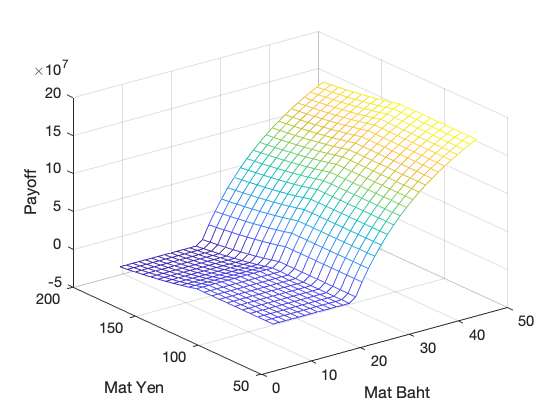

In [12]:
%Diamond Fund TRS 만기 Yen & Baht Scenario Analysis

ns = 1000; Notional = 53000000; Y0 = 122; B0 = 25.884;
Ur = 0.0582; Yr = 0.0058; Br = 0.1008;
Y_vol = 0.075458; B_vol = 0.012436; T=1; rho=0.3;

YT = 122 * (1+[-0.5:0.05:0.5]);
BT = 25.884 * (1+[-0.8:0.05:0.8]);
alpha = zeros(length(YT), length(BT));
for i=1:length(YT)
    for j=1:length(BT)
        alpha(i, j) = max(0, (YT(i) - Y0) / YT(i)) + min(1, 5*(B0-BT(j)) / BT(j));
    end
end
price2 = Notional * (1-0.03-alpha);

%Mesh Graph
[BT, YT] = meshgrid(BT, YT);
mesh(BT, YT, price2)
xlabel('Mat Baht')
ylabel('Mat Yen')
zlabel('Payoff')

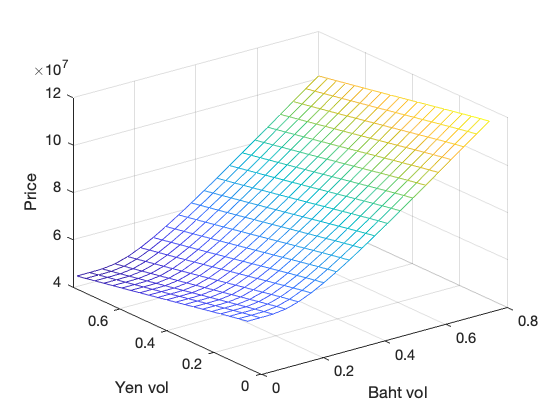

In [13]:
%%Diamond Fund TRS Yen_Vol * Baht_vol Scenario Analysis

ns = 1000; Notional = 53000000; Y0 = 122; B0 = 25.884;
Ur = 0.0582; Yr = 0.0058; Br = 0.1008;
Y_vol = 0.075458; B_vol = 0.012436; T=1; rho=0.3;

Y_vol  = linspace(Y_vol, 0.8, 20);
B_vol  = linspace(B_vol, 0.8, 20);
price3 = zeros(length(Y_vol), length(B_vol));

for i=1:length(Y_vol)
    for j=1:length(B_vol)
        price3(i, j) = GC_TRS(Notional, Y0, B0, Ur, Yr, Br, Y_vol(i), B_vol(j), T);
    end
end

[B_vol, Y_vol] = meshgrid(B_vol, Y_vol);
mesh(B_vol, Y_vol, price3)
xlabel('Baht vol')
ylabel('Yen vol')
zlabel('Price')

In [20]:
%%file MC_IDR.m
%Diamond Fund IDR Monte Carlo Simulation

function [Price, SE, CI] = MC_IDR(Notional, R0, Ur, Ir, I_vol, ns)
    t1 = 0.5; t2 = 1; dt = 0.5;
    R1 = zeros(ns, 1);
    R2 = zeros(ns, 1);
    w  = randn(ns, 2);
    
    for i=1:ns
        R1(i) = R0    / exp((Ur-Ir-I_vol^2/2)*dt + I_vol*sqrt(dt)*w(i, 1));
        R2(i) = R1(i) / exp((Ur-Ir-I_vol^2/2)*dt + I_vol*sqrt(dt)*w(i, 2));
    end
    
    %루피아화 연계채권 만기상환조건
    c1 = 0.2015*(R0./R1)*(1/2);
    c2 = 0.2015*(R0./R1)*(1/2);
    F = max(0, (R0./R2) + 2*(R0-R2)./R2 - (R1-R2)./R2);
    DiscPrice = Notional * c1 * exp(-Ur*t1) + Notional * (F+c2) * exp(-Ur*t2);
    [Price, PriceVar, CI] = normfit(DiscPrice);
    SE = PriceVar/sqrt(ns);

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_IDR.m'.


>1년 미달러화 Libor금리 5.82%, 1년 루피아화 금리 12.25%, 루피아화 연변동성 2.3183%, 매입가격 8,700만달러, 

In [22]:
[Price, PriceVar, CI] = MC_IDR(87000000, 2369.5, 0.0582, 0.1225, 0.023183, 10000000)


Price =

   8.5594e+07


PriceVar =

   1.5029e+03


CI =

   1.0e+07 *

    8.5591
    8.5597



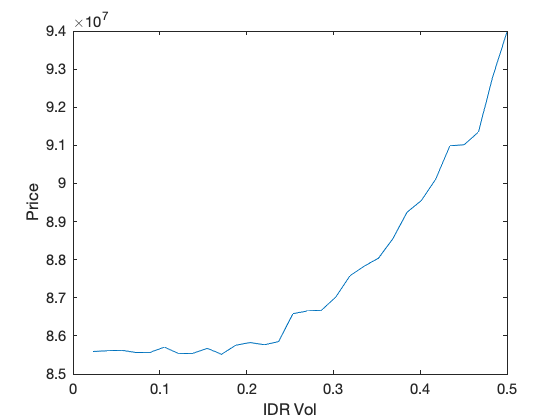

In [23]:
%Diamond Fund IDR Vol Scenario

ns = 100000;
Notional = 87000000;
R0 = 2369.5;
Ur = 0.0582;
Ir = 0.1225;

%IDR_Vol Scenario Analysis (MC)
I_vol = linspace(0.023183, 0.5, 30);
price = [];
for i=1:length(I_vol)
    p     = MC_IDR(Notional, R0, Ur, Ir, I_vol(i), ns);
    price = [price;p];
end

plot(I_vol, price)
xlabel('IDR Vol')
ylabel('Price')